In [ ]:
# 1. Data_preprocessing.py
# 기능: 6개국 원본 상표 데이터를 로드하여 정제하고 하나의 CSV로 통합 저장
# 이 스크립트는 원본 데이터를 읽어 분석 가능한 형태로 정제하고 통합합니다.


# 전처리 방식: 파일 포맷 자동 탐지, 날짜 형식 통일
# 이상치/결측치 처리: 날짜나 분류(류) 정보가 없는 행은 분석 가치가 없으므로 제거(dropna)
# 비정형 데이터 처리: 하나의 상표에 여러 류가 섞여 있는 경우(//, ,) 이를 분리하여 개별 행으로 확장(explode)

import pandas as pd
import os
import sys

# -------------------------------------------------------
# 설정: 파일 경로 및 국가명 매핑
# -------------------------------------------------------
INPUT_FILES = [
    "한국_DATA.xlsx", "미국_DATA.xlsx", "유럽_DATA.xlsx",
    "일본_DATA.xlsx", "중국_DATA.xlsx", "마드리드_DATA.xlsx"
]
OUTPUT_FILE = "integrated_trademark_data.csv"

COUNTRY_NAME_MAP = {
    "한국": "South Korea", "미국": "USA", "유럽": "Europe",
    "일본": "Japan", "중국": "China", "마드리드": "Madrid System"
}

# -------------------------------------------------------
# 함수: 다양한 파일 형식에 대응하는 로더
# -------------------------------------------------------
def load_data_robust(file_name):
    """
    [데이터 로드 방식 설명]
    파일 형식이 엑셀(xlsx)인지 CSV인지, 혹은 인코딩이 UTF-8인지 CP949(한글 윈도우)인지
    사전에 알 수 없으므로, 여러 방식을 순차적으로 시도하여 오류 없이 데이터를 읽어옵니다.
    """
    print(f"[INFO] 파일 로드 시도: {file_name}")

    # 1. Excel 형식 시도
    try:
        return pd.read_excel(file_name)
    except Exception:
        pass

    # 2. CSV 형식 시도 (확장자 변경 후)
    csv_name = file_name.replace('.xlsx', '.csv')
    if not os.path.exists(csv_name):
        return None

    # 3. CSV (UTF-8 인코딩) 시도
    try:
        return pd.read_csv(csv_name, encoding='utf-8')
    except Exception:
        pass

    # 4. CSV (CP949/EUC-KR 인코딩) 시도 - 한글 윈도우 환경 대응
    try:
        return pd.read_csv(csv_name, encoding='cp949')
    except Exception as e:
        print(f"[ERROR] 로드 실패: {e}")
        return None

# -------------------------------------------------------
# 메인 실행 로직
# -------------------------------------------------------
def main():
    df_list = []
    print("[STEP 1] 데이터 로드 및 통합 시작...")

    for file in INPUT_FILES:
        # 파일명에서 국가명 추출 (예: '한국_DATA.xlsx' -> '한국')
        raw_name = file.split('_DATA')[0].replace(' ', '')
        eng_name = COUNTRY_NAME_MAP.get(raw_name, raw_name)

        df = load_data_robust(file)

        if df is not None:
            df['국가'] = eng_name
            # 유사군 컬럼이 없는 국가(해외 데이터)의 경우, 컬럼을 생성하고 비워둠
            if '유사군' not in df.columns:
                df['유사군'] = None
            df_list.append(df)
            print(f"  - {eng_name} 로드 완료 ({len(df):,} 건)")

    if not df_list:
        print("[CRITICAL] 로드된 데이터가 없습니다. 스크립트를 종료합니다.")
        sys.exit()

    # 모든 국가 데이터프레임 하나로 병합
    df_combined = pd.concat(df_list, ignore_index=True)

    print("\n[STEP 2] 데이터 전처리 및 정제 수행...")

    # [전처리 1] 날짜 데이터 표준화
    # '2023.01.01', '20230101' 등 다양한 형식을 YYYY-MM-DD 포맷으로 통일
    # 날짜 변환이 불가능한 이상치는 NaT(Not a Time) 처리 후 제거
    df_combined['출원일자'] = pd.to_datetime(
        df_combined['출원일자'].astype(str).str.replace('.', '').str.strip(),
        format='%Y%m%d', errors='coerce'
    )
    df_combined = df_combined.dropna(subset=['출원일자'])
    df_combined['출원연도'] = df_combined['출원일자'].dt.year.astype(int)

    # [전처리 2] 니스분류(류) 정제 및 Explode 처리
    # 문제점: '3, 5' 또는 '9 // 42' 처럼 하나의 행에 여러 분류가 섞여 있는 경우 존재
    # 해결방안: 구분자를 콤마(,)로 통일하고 분리(split)한 뒤 행을 복제(explode)하여 개별 데이터로 만듦
    df_combined['류'] = df_combined['류'].astype(str).str.replace(r'//', ',', regex=True).str.replace(' ', '')
    df_exploded = df_combined.assign(류=df_combined['류'].str.split(',')).explode('류')

    # 숫자가 아닌 값(오타 등)을 NaN 처리 후 제거
    df_exploded['류'] = pd.to_numeric(df_exploded['류'], errors='coerce')
    df_final = df_exploded.dropna(subset=['류'])

    # [이상치 필터링] 니스분류는 1류~45류까지만 존재하므로 범위를 벗어난 값 제거
    df_final['류'] = df_final['류'].astype(int)
    df_final = df_final[df_final['류'].between(1, 45)]

    print(f"  - 전처리 완료: 총 {len(df_final):,} 건 (유효 데이터 기준)")

    # 최종 결과 저장 (UTF-8-SIG: 엑셀에서 한글 깨짐 방지)
    df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    print(f"\n[COMPLETE] 통합 데이터 저장 완료: {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

[STEP 1] 데이터 로드 및 통합 시작...
[INFO] 파일 로드 시도: 한국_DATA.xlsx
  - South Korea 로드 완료 (49,688 건)
[INFO] 파일 로드 시도: 미국_DATA.xlsx
  - USA 로드 완료 (64,752 건)
[INFO] 파일 로드 시도: 유럽_DATA.xlsx
  - Europe 로드 완료 (52,713 건)
[INFO] 파일 로드 시도: 일본_DATA.xlsx
  - Japan 로드 완료 (13,390 건)
[INFO] 파일 로드 시도: 중국_DATA.xlsx
[INFO] 파일 로드 시도: 마드리드_DATA.xlsx
  - Madrid System 로드 완료 (17,589 건)

[STEP 2] 데이터 전처리 및 정제 수행...
  - 전처리 완료: 총 217,061 건 (유효 데이터 기준)

[COMPLETE] 통합 데이터 저장 완료: integrated_trademark_data.csv


데이터 로드 중...

 [1/2] 한국 시계열 트렌드 분석 (계절성 반영)...
    2023년 데이터 보정 계수(Seasonal Multiplier) 산출 중...
    과거 평균 1~5월 집중도: 39.2%
    적용된 보정 계수: 2.5509 (단순 2.4 대비 정밀화)


/tmp/ipython-input-906841123.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2382.571155233322' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trend_pivot.loc[2023] = trend_pivot.loc[2023] * seasonal_multiplier
/tmp/ipython-input-906841123.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '364.7833781567078' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trend_pivot.loc[2023] = trend_pivot.loc[2023] * seasonal_multiplier
/tmp/ipython-input-906841123.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '785.6872760298321' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trend_pivot.loc[2023] = trend_pivot.loc[2023]

 그래프 저장 완료: result_korea_trend.png
[2/2] 한국 유사군(G/S코드) 상세 분석...
  그래프 저장 완료: result_korea_similar_group.png

[주요 유사군 코드 순위]
   Code  Count
  G1004  18763
  G0209  12040
  G1817  11208
  G1009  10497
  G0502   8907
S174303   8324
S120602   7444
  G0301   7396
  G1005   7340
  S1207   6943


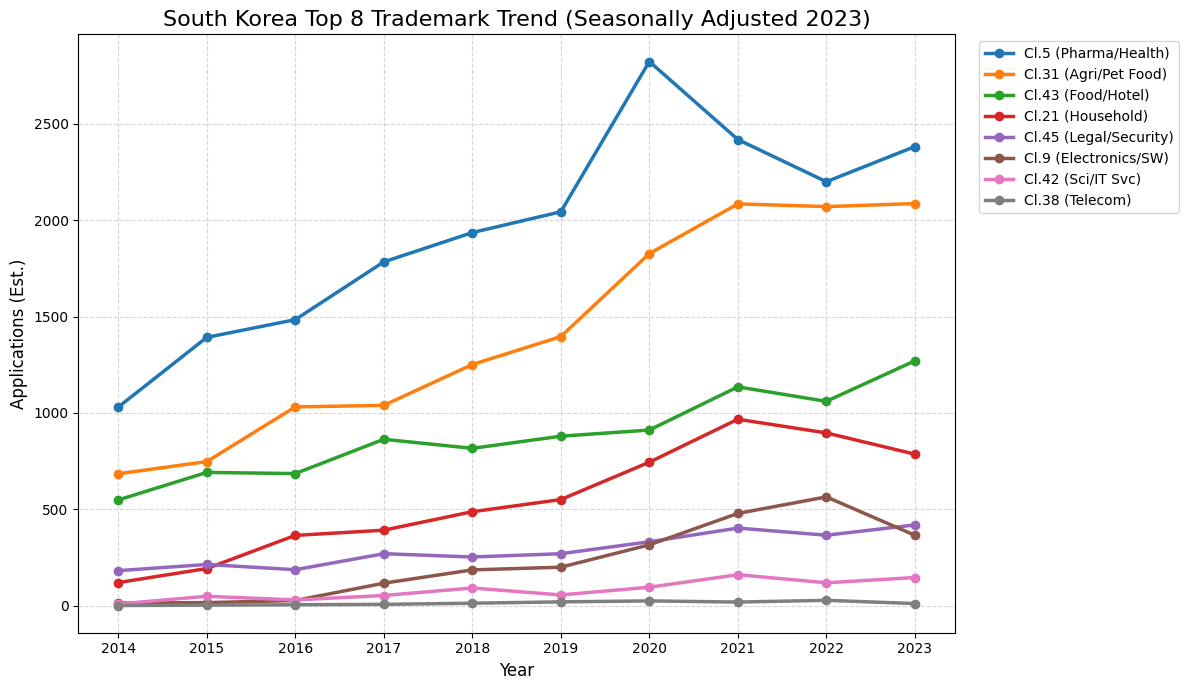

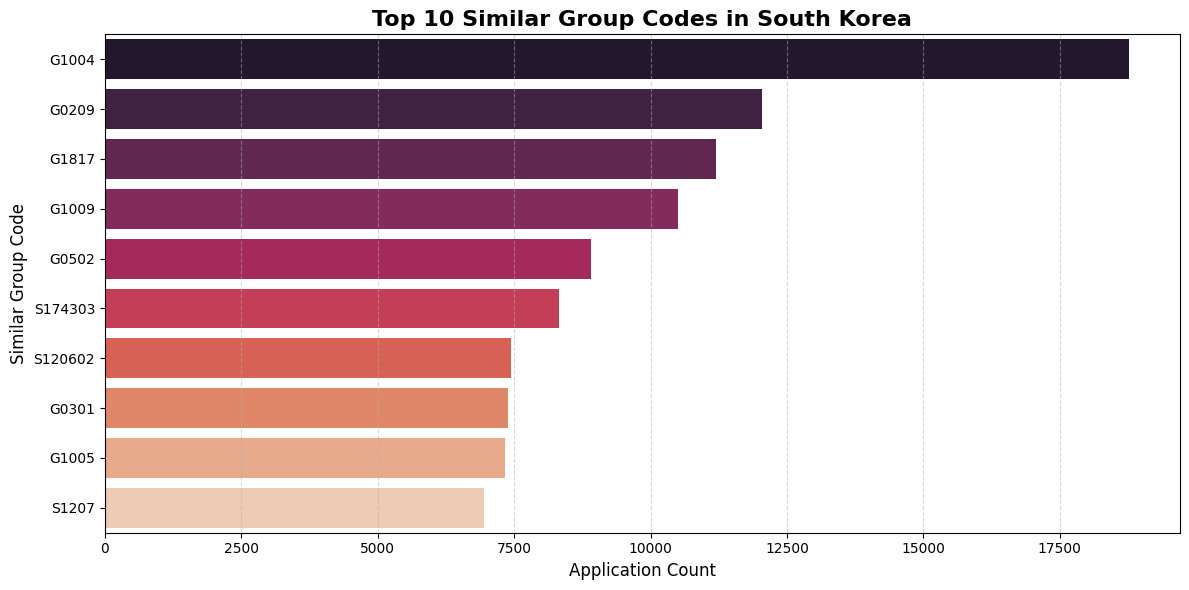

In [ ]:
# 2. Analysis_korea_trend.py
# 기능: 한국 시계열 분석 + 유사군 TOP 10 (계절성 보정 로직 적용)
# 한국 데이터를 타겟으로 추출하여 시계열 변화와 유사군(G/S코드)을 분석합니다.
# 과거 9년치 데이터에서 월(Month) 정보를 추출 후. 연도별 (1~5월 출원량) / (전체 출원량) 비율 계산, 이 비율의 평균값으로 2023년 데이터를 보정.
# 시각화 방식: 시계열 트렌드: Line Chart (흐름 파악 용이), 유사군 순위: Horizontal Bar Chart (긴 텍스트 라벨 표시에 유리)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# 설정
INPUT_FILE = "integrated_trademark_data.csv"

# 시각화 설정 (한글 깨짐 방지용 영문 폰트 사용)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 니스분류 영문 매핑
NCL_MAP_ENG = {
    3: 'Cl.3 (Cosmetics)', 5: 'Cl.5 (Pharma/Health)',
    9: 'Cl.9 (Electronics/SW)', 21: 'Cl.21 (Household)',
    25: 'Cl.25 (Fashion)', 30: 'Cl.30 (Coffee/Food)',
    31: 'Cl.31 (Agri/Pet Food)', 35: 'Cl.35 (Ad/Biz)',
    38: 'Cl.38 (Telecom)', 41: 'Cl.41 (Edu/Content)',
    42: 'Cl.42 (Sci/IT Svc)', 43: 'Cl.43 (Food/Hotel)',
    45: 'Cl.45 (Legal/Security)'
}

def main():
    # 1. 데이터 로드
    try:
        print("데이터 로드 중...")
        df = pd.read_csv(INPUT_FILE)
        # 날짜 컬럼을 datetime 객체로 확실하게 변환
        df['출원일자'] = pd.to_datetime(df['출원일자'])
    except FileNotFoundError:
        print(" 통합 데이터 파일이 없습니다. '1_data_preprocessing.py'를 먼저 실행하세요.")
        sys.exit()

    # 한국 데이터만 필터링
    df_korea = df[df['국가'] == 'South Korea'].copy()

    # 월(Month) 정보 추출
    df_korea['Month'] = df_korea['출원일자'].dt.month

    # =======================================================
    # [PART 1] 시계열 트렌드 분석 (계절성 보정 적용)
    # =======================================================
    print("\n [1/2] 한국 시계열 트렌드 분석 (계절성 반영)...")

    # 분석 기간 설정 (최근 10년)
    target_years = sorted(df_korea['출원연도'].unique())[-10:]
    df_recent = df_korea[df_korea['출원연도'].isin(target_years)]

    # 상위 8개 류(Class) 선정
    top_classes = df_recent['류'].value_counts().nlargest(8).index.tolist()

    # Pivot Table 생성
    trend_pivot = df_recent[df_recent['류'].isin(top_classes)].groupby(['출원연도', '류']).size().unstack(fill_value=0)

    # 2023년 데이터 정밀 보정 로직
    if 2023 in trend_pivot.index:
        print("    2023년 데이터 보정 계수(Seasonal Multiplier) 산출 중...")

        # 과거 9년(2014~2022) 데이터로 '1~5월 출원 비중' 계산
        past_years = range(2014, 2023)
        ratios = []

        for y in past_years:
            yearly_data = df_korea[df_korea['출원연도'] == y]
            total_count = len(yearly_data)
            # 1월~5월 데이터만 필터링
            jan_may_count = len(yearly_data[yearly_data['Month'].between(1, 5)])

            if total_count > 0:
                ratio = jan_may_count / total_count
                ratios.append(ratio)
                # print(f"      - {y}년 1~5월 비중: {ratio*100:.1f}%") # 디버깅용

        # 평균 비중 계산 및 보정 계수 산출
        if ratios:
            avg_ratio = sum(ratios) / len(ratios)
            seasonal_multiplier = 1 / avg_ratio
            print(f"    과거 평균 1~5월 집중도: {avg_ratio*100:.1f}%")
            print(f"    적용된 보정 계수: {seasonal_multiplier:.4f} (단순 2.4 대비 정밀화)")

            # 2023년 데이터에 계수 적용
            trend_pivot.loc[2023] = trend_pivot.loc[2023] * seasonal_multiplier
        else:
            # 과거 데이터가 부족할 경우 기존 방식(2.4) 사용
            print(" 과거 데이터 부족으로 기본 계수(2.4) 사용")
            trend_pivot.loc[2023] = trend_pivot.loc[2023] * 2.4

    # 시계열 그래프 그리기
    plt.figure(figsize=(12, 7))
    colors = sns.color_palette("tab10", n_colors=len(top_classes))

    for i, ncl in enumerate(top_classes):
        label = NCL_MAP_ENG.get(ncl, f"Cl.{ncl}")
        plt.plot(trend_pivot.index, trend_pivot[ncl], marker='o',
                 label=label, linewidth=2.5, color=colors[i])

    plt.title('South Korea Top 8 Trademark Trend (Seasonally Adjusted 2023)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Applications (Est.)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(trend_pivot.index)
    plt.tight_layout()

    plt.savefig('result_korea_trend.png', dpi=300)
    print(" 그래프 저장 완료: result_korea_trend.png")
    # plt.show() # 필요 시 주석 해제

    # =======================================================
    # [PART 2] 유사군(Similar Group Code) TOP 10 분석
    # =======================================================
    print("[2/2] 한국 유사군(G/S코드) 상세 분석...")

    df_sim = df_korea.dropna(subset=['유사군']).copy()
    df_sim['유사군'] = df_sim['유사군'].astype(str).str.replace(r'//', ',', regex=True).str.replace(' ', '')
    df_sim = df_sim.assign(유사군=df_sim['유사군'].str.split(',')).explode('유사군')

    # 유효한 유사군 코드(G 또는 S로 시작 + 숫자) 필터링
    df_sim = df_sim[df_sim['유사군'].str.match(r'^[GS]\d+', na=False)]

    if not df_sim.empty:
        top10_sim = df_sim['유사군'].value_counts().nlargest(10).reset_index()
        top10_sim.columns = ['Code', 'Count']

        plt.figure(figsize=(12, 6))
        sns.barplot(data=top10_sim, x='Count', y='Code', hue='Code', palette='rocket', legend=False)

        plt.title('Top 10 Similar Group Codes in South Korea', fontsize=16, fontweight='bold')
        plt.xlabel('Application Count', fontsize=12)
        plt.ylabel('Similar Group Code', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()

        plt.savefig('result_korea_similar_group.png', dpi=300)
        print("  그래프 저장 완료: result_korea_similar_group.png")

        print("\n[주요 유사군 코드 순위]")
        print(top10_sim.to_string(index=False))
    else:
        print("분석할 유사군 데이터가 없습니다.")

if __name__ == "__main__":
    main()

[INFO] 데이터 로드 중...
[STEP 1] 글로벌 TOP 5 분석 및 시각화 (Log Scale)...
[COMPLETE] 그래프 저장 완료: result_global_top5_log.png


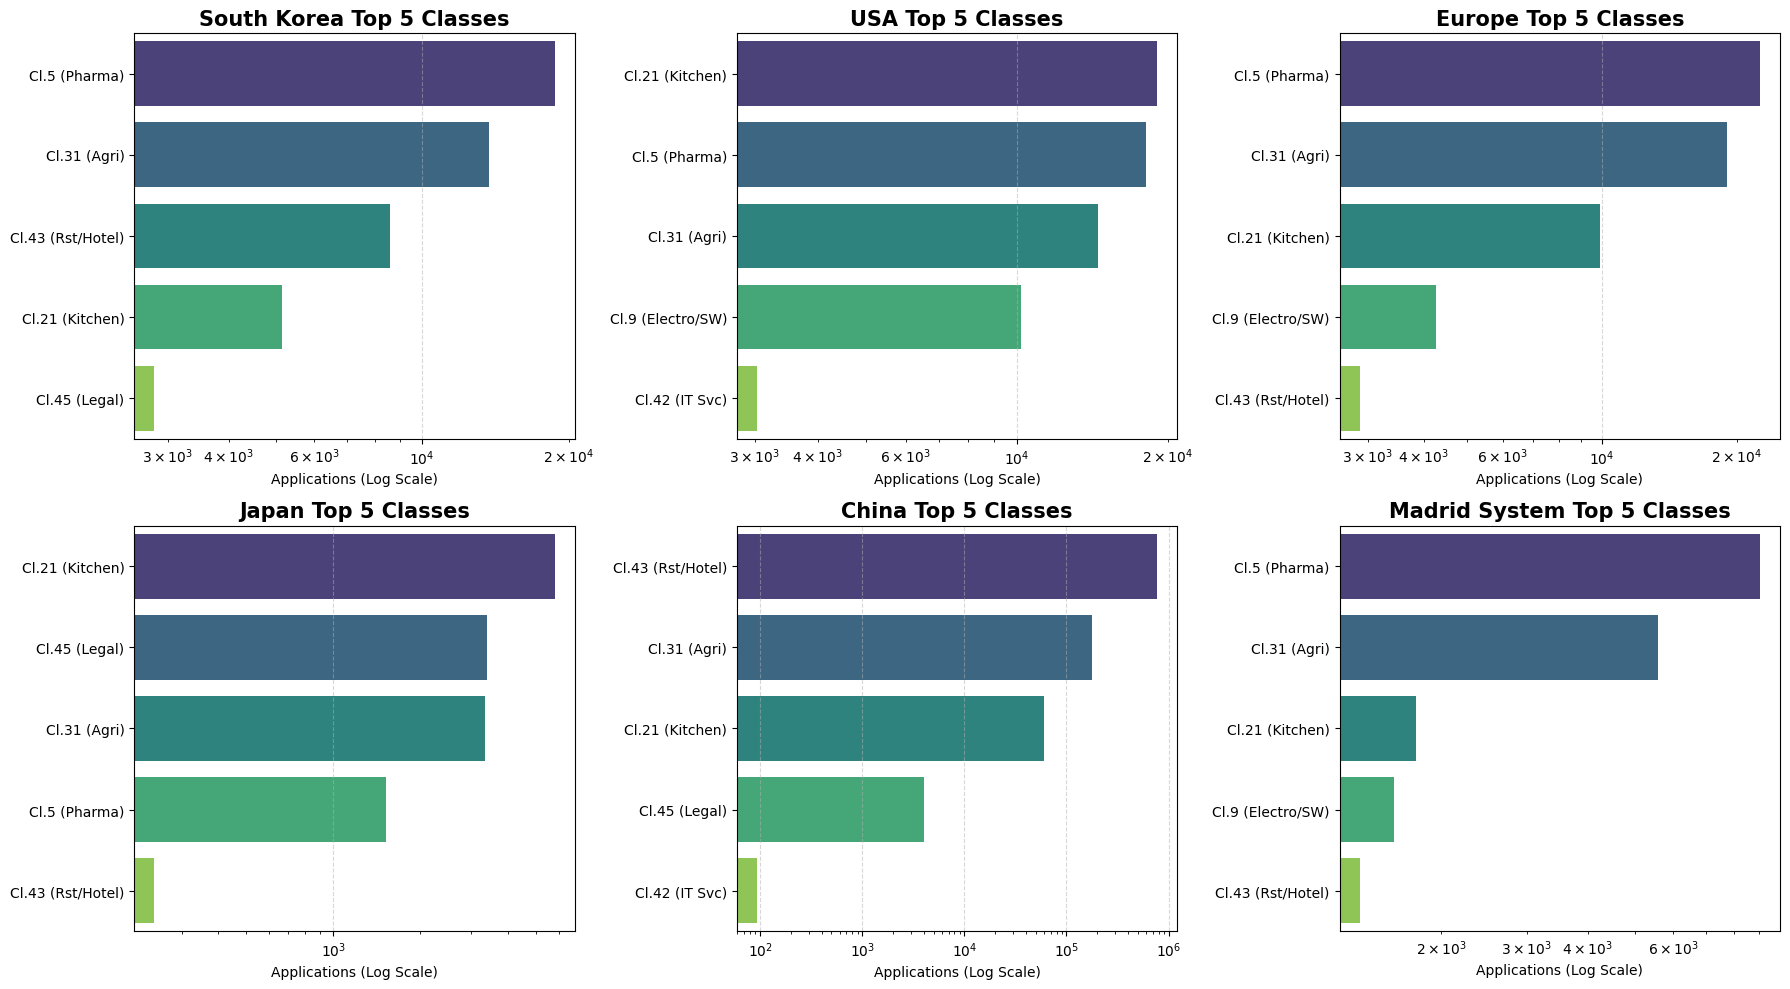

In [ ]:
# 3. Analysis_global_top5_log.py
# 기능: 6개 국가별 출원 빈도 TOP 5 비교 시각화 (Log Scale 적용)
# 이유: 중국(약 70만 건)과 일본/마드리드(수천 건) 간의 데이터 규모 차이가 큼, X축에 로그를 취해 각 국가의 스케일을 상대적으로 비교 가능.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# -------------------------------------------------------
# 설정
# -------------------------------------------------------
INPUT_FILE = "integrated_trademark_data.csv"
COUNTRIES = ['South Korea', 'USA', 'Europe', 'Japan', 'China', 'Madrid System']

# [시각화 설정] 영문 폰트 사용
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 니스분류 영문 매핑 (축약어 사용으로 공간 효율성 증대)
NCL_MAP_ENG = {
    3: 'Cl.3 (Cosmetics)', 5: 'Cl.5 (Pharma)', 9: 'Cl.9 (Electro/SW)',
    14: 'Cl.14 (Jewelry)', 16: 'Cl.16 (Paper)', 18: 'Cl.18 (Leather)',
    21: 'Cl.21 (Kitchen)', 25: 'Cl.25 (Fashion)', 29: 'Cl.29 (Food)',
    30: 'Cl.30 (Coffee)', 31: 'Cl.31 (Agri)', 32: 'Cl.32 (Drinks)',
    35: 'Cl.35 (Ad/Biz)', 36: 'Cl.36 (Finance)', 38: 'Cl.38 (Telecom)',
    41: 'Cl.41 (Edu)', 42: 'Cl.42 (IT Svc)', 43: 'Cl.43 (Rst/Hotel)',
    44: 'Cl.44 (Med)', 45: 'Cl.45 (Legal)'
}

def get_ncl_name(n):
    return NCL_MAP_ENG.get(n, f"Cl.{n}")

def main():
    # 1. 데이터 로드
    try:
        print("[INFO] 데이터 로드 중...")
        df = pd.read_csv(INPUT_FILE)
    except FileNotFoundError:
        print("[ERROR] 통합 데이터 파일이 없습니다.")
        sys.exit()

    # 서브플롯 준비 (2행 3열 구조)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    print("[STEP 1] 글로벌 TOP 5 분석 및 시각화 (Log Scale)...")

    for i, country in enumerate(COUNTRIES):
        ax = axes[i]

        # 국가별 데이터 필터링
        country_data = df[df['국가'] == country]

        if len(country_data) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            continue

        # [전처리] 빈도수 기준 TOP 5 추출
        top5 = country_data['류'].value_counts().nlargest(5).reset_index()
        top5.columns = ['NCL', 'Count']
        top5['Label'] = top5['NCL'].apply(get_ncl_name)

        # [시각화] 막대 그래프
        # hue를 지정하여 Seaborn의 Future Warning 해결
        sns.barplot(
            data=top5,
            x='Count',
            y='Label',
            hue='Label',
            ax=ax,
            palette='viridis',
            legend=False
        )

        # [시각화 옵션 - 핵심] 로그 스케일(Log Scale) 적용
        # 이유: 국가별 출원량 규모(Scale) 차이가 극심함 (예: 중국 70만건 vs 일본 5천건)
        # 일반 선형 축 사용 시 데이터가 작은 국가는 그래프 식별 불가.
        # 로그 스케일을 적용하여 10^3, 10^4, 10^5 단위로 표현함으로써 가독성 확보.
        ax.set_xscale('log')

        ax.set_title(f'{country} Top 5 Classes', fontsize=15, fontweight='bold')
        ax.set_xlabel('Applications (Log Scale)')
        ax.set_ylabel('')
        ax.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()

    save_path = 'result_global_top5_log.png'
    plt.savefig(save_path, dpi=300)
    print(f"[COMPLETE] 그래프 저장 완료: {save_path}")
    plt.show()

if __name__ == "__main__":
    main()